# 3.1D: Exact policy iteration implementation for MDPs
*By: Sudaksh Mishra (Student Id: 222348309)*

Github: https://github.com/sudislife/Taxi-v3-using-policy-iteration (Find the env.yml file here)

In [1]:
import gymnasium as gym
import numpy as np
import time
from gym.utils import seeding
from IPython.display import display
from graphviz import Digraph

In [2]:
# Create the Taxi environment
env_name = 'Taxi-v3'
env = gym.make(env_name, render_mode='human')
env.close()

A finite Markov Decision Process (MDP) is a mathematical model for decision-making problems in which an agent interacts with an environment. It is defined as a tuple $(S, A, R, P, \gamma)$, where:

1. $S$ is a finite set of states.
2. $A$ is a finite set of actions.
3. $R : S \times A \rightarrow \mathbb{R}$ is a reward function that gives the immediate reward the agent receives for taking an action in a particular state.
4. $P : S \times A \times S \rightarrow [0, 1]$ is a transition probability function that gives the probability of moving from one state to another after taking an action in a particular state.
5. $\gamma \in [0, 1]$ is a discount factor that determines the importance of future rewards relative to immediate rewards.

At each time step, the agent observes the current state of the environment, takes an action, and receives a reward based on the action and the new state. The goal of the agent is to find a policy, which is a mapping from states to actions, that maximizes the expected cumulative reward over time.

The finite MDP is called "Markov" because the transition probabilities only depend on the current state and the action taken, and not on the past history of states and actions. This property is called the Markov property, and it simplifies the modeling and analysis of decision-making problems.

The finite MDP is called a "Decision Process" because the agent must make decisions (i.e., select actions) based on the available information and the desired goal.

In [3]:
# Initialize the policy and value function
num_states = env.observation_space.n
num_actions = env.action_space.n
policy = np.ones((num_states, num_actions)) / num_actions
value = np.zeros(num_states)

In [4]:
# Define the discount factor and the convergence threshold
discount_factor = 0.9
theta = 0.0001

The code below has been made via the pseudocode provided here: https://medium.com/@ngao7/markov-decision-process-policy-iteration-42d35ee87c82\
The pseudocode for policy evaluation:\
<code>
converge &larr; false\
while converge = false do:\
    &nbsp;&nbsp;$\Delta$ &larr; 0\
    &nbsp;&nbsp;for s $\in$ S do\
        &nbsp;&nbsp;&nbsp;&nbsp;temp &larr; v(s)\
        &nbsp;&nbsp;&nbsp;&nbsp;v(s) &larr; r(s) + $\gamma \sum_{s'}p(s'|s,a=\pi(s))v(s')$\
        &nbsp;&nbsp;&nbsp;&nbsp;$\Delta$ &larr; $max(\Delta,|temp-v(s)|)$\
    &nbsp;&nbsp;end\
    &nbsp;&nbsp;if $\Delta < \theta$ then\
    &nbsp;&nbsp;&nbsp;&nbsp;converge &larr; true\
    &nbsp;&nbsp;end\
end
return v(s)
</code>

And the pseudocode for policy improvement:\
<code>
change &larr; false\
for s $\in$ S do\
    &nbsp;&nbsp;temp &larr; $\pi$(s)\
    &nbsp;&nbsp;$\pi$(s) &larr; $argmax_a \sum_{s'}p(s'|s,a)v(s')$\
    &nbsp;&nbsp;if change $\neq \pi$(s) then\
    &nbsp;&nbsp;&nbsp;&nbsp;converge &larr; true\
    &nbsp;&nbsp;end\
end\
return $\pi$(s), change
</code>

In [5]:
# Iterate until convergence
while True:
    # Policy evaluation step
    while True:
        delta = 0
        for state in range(num_states):
            v = value[state]
            action_values = np.zeros(num_actions)
            for action in range(num_actions):
                for prob, next_state, reward, done in env.P[state][action]:
                    action_values[action] += prob * (reward + discount_factor * value[next_state])
                value[state] = np.max(action_values)
            # Check for change in value function
            delta = max(delta, abs(v - value[state]))
        # Convergence check
        if delta < theta:
            break
            
    # Policy improvement step
    policy_stable = True
    for state in range(num_states):
        old_action = np.argmax(policy[state])
        action_values = np.zeros(num_actions)
        for action in range(num_actions):
            for prob, next_state, reward, done in env.P[state][action]:
                action_values[action] += prob * (reward + discount_factor * value[next_state])
        best_action = np.argmax(action_values)
        # Check for change in policy
        if old_action != best_action:
            policy_stable = False
        policy[state] = np.eye(num_actions)[best_action]
    # Convergence check
    if policy_stable:
        break

In [6]:
# Print the final policy and value function
print('Final policy:')
print(policy)

Final policy:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [7]:
env = gym.make(env_name, render_mode='human')
observation, info = env.reset(seed = 0)
print('Initial state:', observation)
for t in range(100):
    time.sleep(0.5)
    action = np.argmax(policy[observation])
    observation, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.close()

Initial state: 314


C:\Users\sudak\anaconda3\envs\gym\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [8]:
# Average reward over 1000 steps
env = gym.make(env_name, render_mode='human')
observation, info = env.reset()
total_reward = 0
step_counter = 0
for t in range(1000):
    step_counter += 1
    action = np.argmax(policy[observation])
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break
env.close()

print('Average reward:', total_reward / step_counter)

Average reward: 0.75


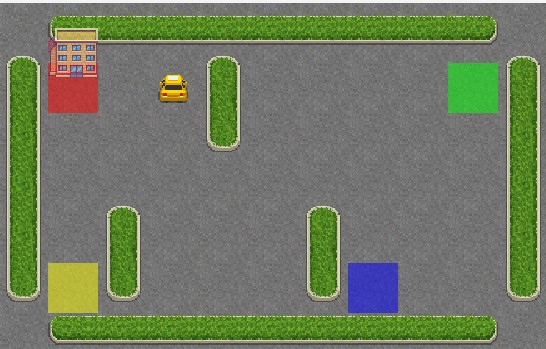

The class and the function below are taken from the mdp.py file given in Week 3 Workshop Resources to help with plotting the graphical model.\
The class function has been modified to take env.P as its input.

In [9]:
class MDP:
    def __init__(self, P=None, transition_probs=None, rewards=None, initial_state=None, seed=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.

        States and actions can be anything you can use as dict keys, but we recommend that you use strings or integers

        Here's an example from MDP depicted on http://bit.ly/2jrNHNr
        transition_probs = {
            's0': {
                'a0': {'s0': 0.5, 's2': 0.5},
                'a1': {'s2': 1}
            },
            's1': {
                'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
                'a1': {'s1': 0.95, 's2': 0.05}
            },
            's2': {
                'a0': {'s0': 0.4, 's2': 0.6},
                'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
            }
        }
        rewards = {
            's1': {'a0': {'s0': +5}},
            's2': {'a1': {'s0': -1}}
        }
        """
        if P is not None:
            transition_probs = {}
            rewards = {}

            for state in P:
                rewards['S' + str(state)] = {}
                transition_probs['S' + str(state)] = {}
                for action in P[state]:
                    rewards['S' + str(state)]['A' + str(action)] = {'S' + str(P[state][action][0][1]): P[state][action][0][2]}
                    transition_probs['S' + str(state)]['A' + str(action)] = {'S' + str(P[state][action][0][1]): P[state][action][0][0]}

        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()
        self.np_random, _ = seeding.np_random(seed)

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = self.np_random.choice(
                tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError(
                "initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = possible_states[self.np_random.choice(np.arange(len(possible_states)), p=probs)]
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), \
                "transition_probs for %s should be a dictionary but is instead %s" % (
                    state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), \
                    "transition_probs for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(transition_probs[state][action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, \
                    "next state probabilities for state %s action %s add up to %f (should be 1)" % (
                        state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), \
                "rewards for %s should be a dictionary but is instead %s" % (
                    state, type(rewards[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), \
                    "rewards for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(rewards[state][action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance."
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg

In [10]:
def plot_graph(mdp, graph_size='10,10', s_node_size='1,5',
               a_node_size='0,5', rankdir='LR', ):
    """
    Function for pretty drawing MDP graph with graphviz library.
    Requirements:
    graphviz : https://www.graphviz.org/
    for ubuntu users: sudo apt-get install graphviz
    python library for graphviz
    for pip users: pip install graphviz
    :param mdp:
    :param graph_size: size of graph plot
    :param s_node_size: size of state nodes
    :param a_node_size: size of action nodes
    :param rankdir: order for drawing
    :return: dot object
    """
    s_node_attrs = {'shape': 'doublecircle',
                    'color': '#85ff75',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

    a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

    s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

    a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

    graph = Digraph(name='MDP')
    graph.attr(rankdir=rankdir, size=graph_size)
    for state_node in mdp._transition_probs:
        graph.node(state_node, **s_node_attrs)

        for posible_action in mdp.get_possible_actions(state_node):
            action_node = state_node + "-" + posible_action
            graph.node(action_node,
                       label=str(posible_action),
                       **a_node_attrs)
            graph.edge(state_node, state_node + "-" +
                       posible_action, **s_a_edge_attrs)

            for posible_next_state in mdp.get_next_states(state_node,
                                                          posible_action):
                probability = mdp.get_transition_prob(
                    state_node, posible_action, posible_next_state)
                reward = mdp.get_reward(
                    state_node, posible_action, posible_next_state)

                if reward != 0:
                    label_a_s_edge = 'p = ' + str(probability) + \
                                     '  ' + 'reward =' + str(reward)
                else:
                    label_a_s_edge = 'p = ' + str(probability)

                graph.edge(action_node, posible_next_state,
                           label=label_a_s_edge, **a_s_edge_attrs)
    return graph

# Graphical Model

In [11]:
# Convert policy to dictionary
policy_dict = {}
rewards = {}
for state in range(num_states):
    policy_dict['S' + str(state)] = {}
    rewards['S' + str(state)] = {}

for state in range(num_states):
    policy_dict['S' + str(state)]['A' + str(np.argmax(policy[state]))] = {'S' + str(env.P[state][np.argmax(policy[state])][0][1]): env.P[state][np.argmax(policy[state])][0][0]}
    rewards['S' + str(state)]['A' + str(np.argmax(policy[state]))] = {'S' + str(env.P[state][np.argmax(policy[state])][0][1]): env.P[state][np.argmax(policy[state])][0][2]}

In [12]:
# Graph of all possible Actions and States
display(plot_graph(MDP(env.P, seed=0, initial_state='S314')))

# Report

## Introduction
The "Taxi-v3" environment in OpenAI's Gym is a popular testbed for reinforcement learning algorithms. In this environment, a taxi navigates through a grid-world to pick up and drop off passengers at specified locations. The taxi must navigate around walls and avoid illegal actions, such as trying to pick up a passenger that is not at the current location. The code provided in the notebook applies the Policy Iteration algorithm to solve for the optimal policy.

## Conceptual Overview
### Policy Iteration
The Policy Iteration algorithm is a dynamic programming method that can be used to solve MDPs. It consists of two steps: policy evaluation and policy improvement. In the first step, the algorithm evaluates the value of each state under the current policy, by iteratively updating the value function until convergence. In the second step, the algorithm improves the policy by greedily choosing the action that maximizes the expected return from each state, based on the updated value function.

### Pseudocode for policy iteration method 
The pseudocode for policy evaluation:\
<code>
converge &larr; false\
while converge = false do:\
    &nbsp;&nbsp;$\Delta$ &larr; 0\
    &nbsp;&nbsp;for s $\in$ S do\
        &nbsp;&nbsp;&nbsp;&nbsp;temp &larr; v(s)\
        &nbsp;&nbsp;&nbsp;&nbsp;v(s) &larr; r(s) + $\gamma \sum_{s'}p(s'|s, a=\pi(s))v(s')$\
        &nbsp;&nbsp;&nbsp;&nbsp;$\Delta$ &larr; $max(\Delta,|temp-v(s)|)$\
    &nbsp;&nbsp;end\
    &nbsp;&nbsp;if $\Delta < \theta$ then\
    &nbsp;&nbsp;&nbsp;&nbsp;converge &larr; true\
    &nbsp;&nbsp;end\
end
return v(s)
</code>

And the pseudocode for policy improvement:\
<code>
change &larr; false\
for s $\in$ S do\
    &nbsp;&nbsp;temp &larr; $\pi$(s)\
    &nbsp;&nbsp;$\pi$(s) &larr; $argmax_a \sum_{s'}p(s'|s,a)v(s')$\
    &nbsp;&nbsp;if change $\neq \pi$(s) then\
    &nbsp;&nbsp;&nbsp;&nbsp;converge &larr; true\
    &nbsp;&nbsp;end\
end\
return $\pi$(s), change
</code>

Here 's' is state, 'S' is set of all states, 'v(s)' is the estimated value of the state, 'r' is the reward, 'p(s',r|s, a)' is the transition probability function that describes the probability of transitioning to state 's'' and receiving reward 'r', '$\pi$(s)' is the best action to take at state 's', '$\gamma$' is the discount factor, '$\theta$' is the threshold for convergence, 

The policy evaluation step is implemented using a nested loop that iteratively updates the value function until convergence ($\Delta < \theta$). The outer loop continues until the change in the value function for all states is below a predefined threshold. The inner loop updates the value function for each state by greedily choosing the action that maximizes the expected return, based on the current policy.

The policy improvement step is implemented using another loop that greedily chooses the action that maximizes the expected return from each state, based on the updated value function. The loop also checks for policy stability by comparing the previous policy to the new policy. If the policies are the same ($\pi(s) = \pi(s')$), the algorithm has converged and the optimal policy has been found.

One of the strengths of the Policy Iteration algorithm is that it always converges to the optimal policy in a finite number of iterations, as long as the MDP is finite and the discount factor is less than one. However, the algorithm may be computationally expensive, especially for large MDPs, as it involves solving a linear system of equations for each policy evaluation step.

### Result after running the policy iteration on Taxi-v3


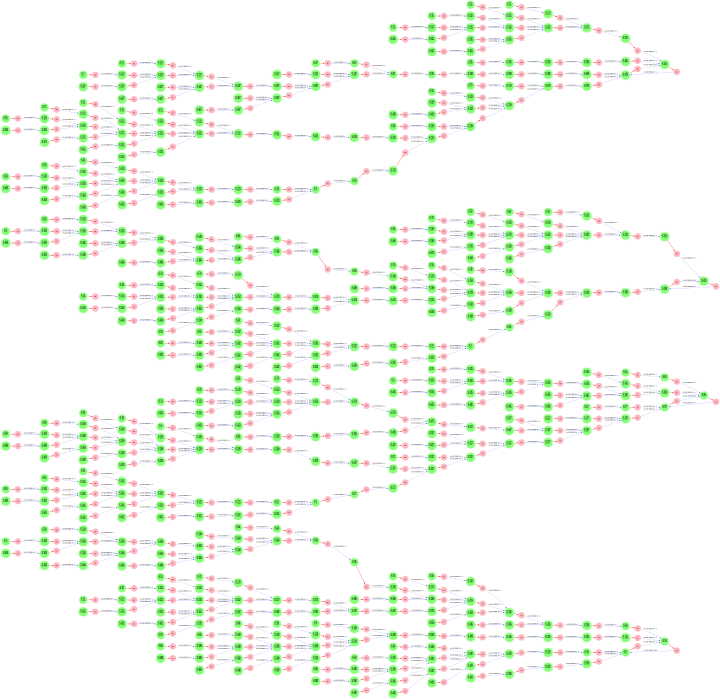

In [13]:
# Graph of the policy after policy iteration
display(plot_graph(MDP(transition_probs = policy_dict, rewards = rewards, seed=0, initial_state='S314')))

## Conclusion
The implementation of the Policy Iteration algorithm in the Taxi-v3 environment demonstrates the application of dynamic programming methods to solve MDPs. The algorithm consists of two steps: policy evaluation and policy improvement, and always converges to the optimal policy in a finite number of iterations. However, the algorithm may be computationally expensive, especially for large MDPs. Overall, the implementation provides a good example of how dynamic programming can be used to solve MDPs and optimize decision-making in complex environments.